In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
HTML("""
<style>
.jp-Stdin-input {
    width: 80% !important;
    height : 1.5em !important;
    font-size : 1em;
    background : white;
    border:1px solid #cccccc;
}
</style>
""")

In [2]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

In [3]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [30]:
vec = pickle.load(open('preprocess/MIMIC/vec_admit_only.p', 'rb'))

freq = np.zeros((vec.vocab_size, ))
for x in vec.seqs['train'] :
    for w in x :
        freq[w] += 1
freq = freq / np.sum(freq)
vec.freq = freq

In [5]:
import model.Attn_Readmit_Pert as M
Model = M.Model

In [6]:
X, Xt = vec.seqs['train'], vec.seqs['test']
y, yt = vec.labels['train'], vec.labels['test']

In [7]:
len_t = np.argsort([len(x) for x in Xt])
Xt = [Xt[i] for i in len_t]
yt = [yt[i] for i in len_t]

In [8]:
pos_weight = len(y)/sum(y) - 1

In [11]:
from sklearn.metrics import classification_report, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, 32, dirname='mimic', hidden_size=128, pre_embed=vec.embeddings, pos_weight=pos_weight)
    best_f1 = 100.0
    for i in tqdm_notebook(range(10)) :
        loss = model.train(X, y, shuffle_batches=False)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        f1 = np.abs(f1_score(yt, (o > 0.5), pos_label=1) - f1_score(yt, (o > 0.5), pos_label=0))
        print(rep)
        stmt = '%s, %s' % (i, loss)
        if f1 < best_f1 :
            best_f1 = f1
            dirname = model.save_values(add_name=name, save_model=True)
            print("Model Saved", f1)
        else :
            dirname = model.save_values(add_name=name, save_model=False)
            print("Model not saved", f1)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [ ]:
train(name='TEST_embedding_without_bias_preproc')

# **EVALUATION**

In [13]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, 32, dirname='mimic', hidden_size=128, pre_embed=vec.embeddings)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [14]:
model = load_model('outputs/readmit_mimic_pert_mimic/ThuOct412:27:252018_TEST_embedding_without_bias_preproc/')

Setting Embedding


In [15]:
o, he = model.evaluate(Xt)
o = np.array(o)
rep = classification_report(yt, (o > 0.5))
print(rep)

              precision    recall  f1-score   support

           0       0.74      0.38      0.51       551
           1       0.39      0.74      0.51       291

   micro avg       0.51      0.51      0.51       842
   macro avg       0.56      0.56      0.51       842
weighted avg       0.62      0.51      0.51       842



In [16]:
from IPython.core.display import display, HTML
import re
def print_attn(sentence, attention) :
    l = []
    for w, a in zip(sentence, attention) :
        w = re.sub('&', '&amp;', w)
        w = re.sub('<', '&lt;', w)
        w = re.sub('>', '&gt;', w)
        
        l.append('<span style="background-color:hsl(360,100%,' + str((1-a) * 50 + 50) + '%)">' + w + ' </span>')
    display(HTML(''.join(l)))

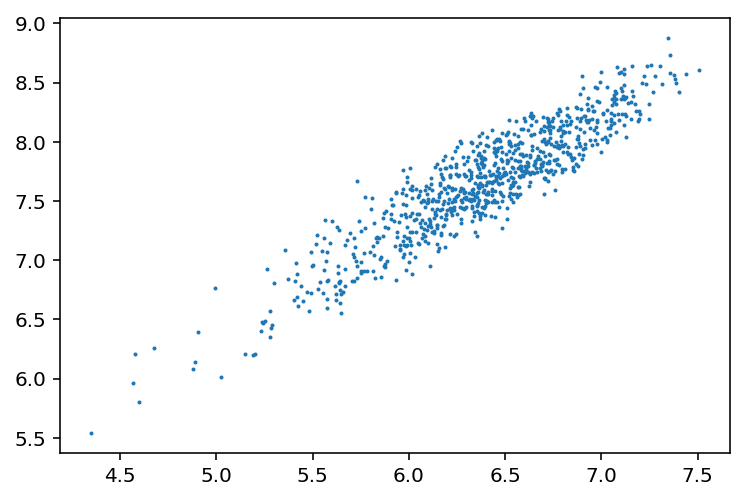

In [17]:
def calc_entropy(i) :
    h = he[i][:len(Xt[i])]
    a = h * np.log(np.clip(h, a_min=1e-8, a_max=None))
    a = -a.sum()
    return a, np.log(len(Xt[i])) 
entropy = [calc_entropy(i) for i in range(len(he))]

x1, y1 = zip(*entropy)
plt.scatter(x1, y1, s=1)

In [18]:
print(np.argsort([max(x) for x in he])[-10:])
print(max([max(x) for x in he]))

[20  4  9 13 10  8 12  2  0  1]
0.08032749


# __SAMPLING__

In [ ]:
model.vec = vec
output = model.sampling(Xt, sample_vocab=50)

In [ ]:
perts_attn, words_sampled, best_attn_idxs = output

In [ ]:
perts_attn_med = [np.median(perts_attn[i], 1) for i in range(len(perts_attn))]

In [ ]:
meds, attn_meds = [], []
for i in range(len(perts_attn)) :
    m = perts_attn_med[i]
    for j in range(10) :
        meds.append(m[best_attn_idxs[i][j], j])
        attn_meds.append(he[i][best_attn_idxs[i][j]])

In [ ]:
plt.scatter(attn_meds, meds, s=1)

In [ ]:
def plot_diff(sentence_1, idx, new_word, old_attn, new_attn) :
    L = len(sentence_1)
    print_attn(sentence_1, old_attn[:L])
    sentence_1 = [x for x in sentence_1]
    sentence_1[idx] = vec.idx2word[new_word]
    print("="*20)
    print_attn(sentence_1, new_attn[:L])

In [ ]:
n = 75
w = 5
plot_diff(map2words(Xt[n]), 
          best_attn_idxs[n][0], 
          int(words_sampled[n][w]), 
          he[n][:], 
          perts_attn[n][:, w, 0])

# **LOGISTIC REGRESSION**

In [36]:
vec.bow = {'train' : None, 'test' : None}
for k in vec.bow.keys() :
    vec.bow[k] = np.zeros((len(vec.seqs[k]), vec.vocab_size))
    for i, s in enumerate(vec.seqs[k]) :
        for x in s :
            vec.bow[k][i, x] += 1
    vec.bow[k] = vec.bow[k][:, 4:]

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfconv = TfidfTransformer()

vec.tfidf = { 'train' : None, 'test' : None }
vec.tfidf['train'] = tfconv.fit_transform(vec.bow['train'])
vec.tfidf['test'] = tfconv.transform(vec.bow['test'])

In [38]:
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(loss='log', class_weight='balanced', penalty='l1')

In [39]:
model_sgd.fit(vec.tfidf['train'], vec.labels['train'])

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
pred = model_sgd.predict(vec.tfidf['test'])
rep = classification_report(yt, pred)
print(rep)

              precision    recall  f1-score   support

           0       0.68      0.44      0.54       551
           1       0.36      0.60      0.45       291

   micro avg       0.50      0.50      0.50       842
   macro avg       0.52      0.52      0.50       842
weighted avg       0.57      0.50      0.51       842



In [41]:
abs_coef = np.abs(model_sgd.coef_[0])
# abs_coef = abs_coef / sum(abs_coef)

In [42]:
attns, lrc = [], []
for i in range(len(he)) :
    a = he[i][1:len(Xt[i])-1]
    attns += list(a)
    for j in Xt[i][1:-1] :
        lrc.append(abs_coef[j-4])

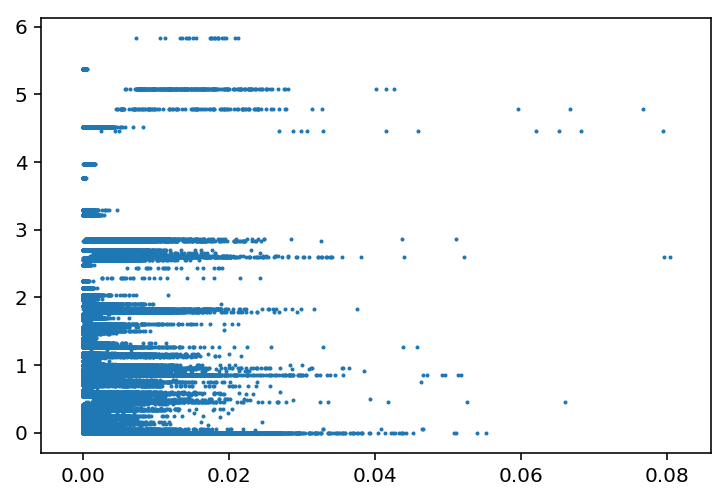

In [43]:
plt.scatter(attns, lrc, s=1)

In [44]:
vec.map2words_shift(np.argsort(abs_coef)[-20:])

['patient',
 'metastatic',
 'postoperative',
 'seizure',
 'ascites',
 ';',
 'renal',
 'peg',
 'up',
 'respiratory',
 'for',
 'graft',
 'refills',
 'disp',
 'expired',
 'at',
 'subdural',
 'trach',
 'ml',
 'infant']

In [47]:
c0 = np.clip(vec.bow['train'], a_min=0, a_max=1)[np.array(vec.labels['train']) == 0].sum(0)
c1 = np.clip(vec.bow['train'], a_min=0, a_max=1)[np.array(vec.labels['train']) == 1].sum(0)

pxy1 = c1 / sum(vec.labels['train'])
pxy0 = c0 / (len(vec.labels['train']) - sum(vec.labels['train']))

vec.map2words_shift(np.argsort(np.abs(np.log(pxy1) - np.log(pxy0)))[-20:])

/home/sarthak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


['cardic',
 'dependance',
 'convex',
 'asterixes',
 'psurgh',
 'adf',
 'flolan',
 'anisocytosis',
 'triads',
 'sonata',
 'vad',
 'gtcs',
 'frontally',
 'malposition',
 'dn',
 'menstruation',
 'adhered',
 'asthmacort',
 'psychopharmacology',
 'txp']